## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Importing all the tools

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
import time

Dictionary for genre id's that will be used later

In [2]:
genre_dict = {"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},{"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},{"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},{"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},{"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},{"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},{"id":37,"name":"Western"}]}

In [130]:
genre_dict_2 = {}
for dict in range(0,len(genre_dict['genres'])):
    genre_dict_2[genre_dict['genres'][dict]['id']] = genre_dict['genres'][dict]['name']
print(genre_dict_2)

{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


In [223]:
ratings_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.ratings.csv.gz")
title_basics_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.basics.csv.gz")
gross_income_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\bom.movie_gross.csv.gz")
budgets_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\tn.movie_budgets.csv.gz")
name_basics_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.name.basics.csv.gz")
movie_info_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\rt.movie_info.tsv.gz", sep='\t')
title_crew_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.crew.csv.gz")
title_principals_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.principals.csv.gz")
tmdb_movie_info_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\tmdb.movies.csv.gz")


In [235]:
ratings_basics = pd.merge(ratings_df, title_basics_df)

In [5]:
basics_ratings_directors_df = pd.merge(ratings_basics, title_crew_df)


In [6]:
movie_and_budget = pd.merge(budgets_df, tmdb_movie_info_df, left_on='movie', right_on='title')

In [7]:
movie_and_budget[movie_and_budget.columns[3:6]] = movie_and_budget[movie_and_budget.columns[3:6]].replace('[\$,]', '', regex=True).astype(float)

In [8]:
movie_and_budget['profit'] = movie_and_budget['worldwide_gross'] - movie_and_budget['production_budget']

In [14]:
movie_and_budget_last_5years = movie_and_budget[movie_and_budget['release_date_y'].str.contains('2016') | 
                 movie_and_budget['release_date_y'].str.contains('2017') |
                 movie_and_budget['release_date_y'].str.contains('2018') |
                 movie_and_budget['release_date_y'].str.contains('2019') |
                 movie_and_budget['release_date_y'].str.contains('2020')]

In [16]:
movie_and_budget_last_5years = movie_and_budget_last_5years[movie_and_budget_last_5years['release_date_x'].str.contains('2016') | 
                 movie_and_budget_last_5years['release_date_x'].str.contains('2017') |
                 movie_and_budget_last_5years['release_date_x'].str.contains('2018') |
                 movie_and_budget_last_5years['release_date_x'].str.contains('2019') |
                 movie_and_budget_last_5years['release_date_x'].str.contains('2020')]

In [19]:
movie_and_budget_last_5years = movie_and_budget_last_5years.drop_duplicates(subset=['id_x','id_y'])

In [21]:
movie_and_budget_last_5years = movie_and_budget_last_5years[movie_and_budget_last_5years['original_language'].str.contains('en')]

In [28]:
movie_and_budget_last_5years.sort_values(by=['profit'], ascending=False).head(15)

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count,profit
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,1.748134e+09
36,42,"Feb 16, 2018",Black Panther,200000000.0,700059566.0,1.348258e+09,23817,"[28, 12, 14, 878]",284054,en,Black Panther,44.140,2018-02-16,Black Panther,7.4,12365,1.148258e+09
98,13,"Jun 22, 2018",Jurassic World: Fallen Kingdom,170000000.0,417719760.0,1.305773e+09,23829,"[28, 12, 878]",351286,en,Jurassic World: Fallen Kingdom,34.958,2018-06-22,Jurassic World: Fallen Kingdom,6.5,5995,1.135773e+09
118,35,"Mar 17, 2017",Beauty and the Beast,160000000.0,504014165.0,1.259200e+09,20627,"[10751, 14, 10749]",321612,en,Beauty and the Beast,31.793,2017-03-17,Beauty and the Beast,6.9,11023,1.099200e+09
37,44,"Jun 15, 2018",Incredibles 2,200000000.0,608581744.0,1.242521e+09,23826,"[28, 12, 16, 10751]",260513,en,Incredibles 2,36.286,2018-06-15,Incredibles 2,7.6,6354,1.042521e+09
122,36,"Dec 21, 2018",Aquaman,160000000.0,335061807.0,1.146895e+09,23824,"[28, 12, 14]",297802,en,Aquaman,38.102,2018-12-21,Aquaman,6.8,6155,9.868946e+08
18,23,"Apr 14, 2017",The Fate of the Furious,250000000.0,225764765.0,1.234846e+09,20630,"[28, 80, 53]",337339,en,The Fate of the Furious,28.668,2017-04-14,The Fate of the Furious,6.9,6335,9.848463e+08
400,30,"Jun 30, 2017",Despicable Me 3,75000000.0,264624300.0,1.034728e+09,20686,"[28, 16, 35, 10751, 12]",324852,en,Despicable Me 3,16.407,2017-06-30,Despicable Me 3,6.3,4106,9.597278e+08
13,17,"May 6, 2016",Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,17382,"[12, 28, 878]",271110,en,Captain America: Civil War,39.137,2016-05-06,Captain America: Civil War,7.4,14000,8.900694e+08
326,38,"Dec 20, 2017",Jumanji: Welcome to the Jungle,90000000.0,404508916.0,9.644962e+08,20661,"[28, 12, 35, 14]",353486,en,Jumanji: Welcome to the Jungle,20.395,2017-12-20,Jumanji: Welcome to the Jungle,6.7,7213,8.744962e+08


In [30]:
movie_and_budget_last_5years['release_date_y']= pd.to_datetime(movie_and_budget_last_5years['release_date_y'])

In [36]:
movie_and_budget_last_5years['month'] = pd.to_datetime(movie_and_budget_last_5years['release_date_y']).dt.month

In [142]:

movie_and_budget_last_5years = movie_and_budget_last_5years.join(pd.DataFrame(movie_and_budget_last_5years["genre_ids"].values.tolist(), movie_and_budget_last_5years.index).add_prefix('genre_'))



In [144]:
for y in range(0,7):
    movie_and_budget_last_5years['genre_'+str(y)] = pd.to_numeric(movie_and_budget_last_5years['genre_'+str(y)], errors='coerce')

In [145]:
movie_and_budget_last_5years['genre_0'][3]

12.0

In [146]:
for y in range(0,7):
    movie_and_budget_last_5years['genre_'+str(y)] = movie_and_budget_last_5years['genre_'+str(y)].map(genre_dict_2)


In [141]:
movie_and_budget_last_5years = movie_and_budget_last_5years.drop(columns=['genre_0', 'genre_1','genre_2','genre_3','genre_4','genre_5','genre_6'])

In [148]:
avg_profit = movie_and_budget_last_5years.groupby(['month']).mean().sort_values(by=['profit'], ascending=False)
median_profit = movie_and_budget_last_5years.groupby(['month']).median().sort_values(by=['profit'], ascending=False)
std_profit = movie_and_budget_last_5years.groupby(['month']).std().sort_values(by=['profit'], ascending=False)

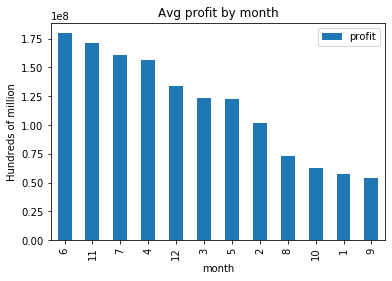

In [149]:
avg_profit[['profit']].plot(kind='bar')
plt.title('Avg profit by month')
plt.ylabel('Hundreds of million');

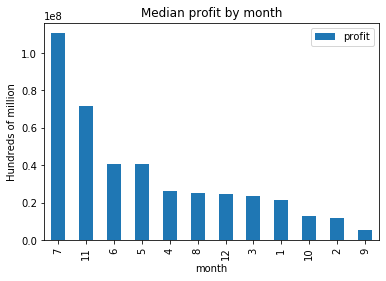

In [151]:
median_profit[['profit']].plot(kind='bar')
plt.title('Median profit by month')
plt.ylabel('Hundreds of million');

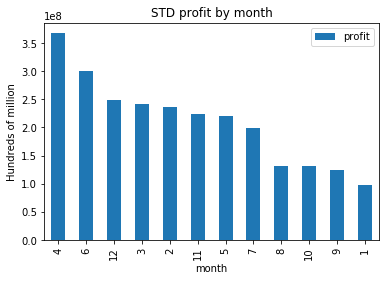

In [152]:
std_profit[['profit']].plot(kind='bar')
plt.title('STD profit by month')
plt.ylabel('Hundreds of million');

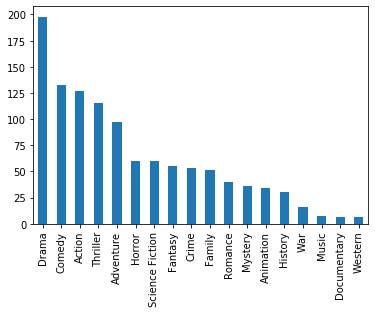

In [186]:
movie_and_budget_last_5years[['genre_0', 'genre_1','genre_2','genre_3']].apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).plot(kind='bar')

In [155]:
movie_and_budget_last_5years.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_y,original_language,...,profit,month_year,month,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,23811,"[12, 28, 14]",299536,en,...,1.748134e+09,2018-04,4,Adventure,Action,Fantasy,NaN,NaN,NaN,NaN
4,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,6.559452e+08,20623,"[28, 12, 14, 878]",141052,en,...,3.559452e+08,2017-11,11,Action,Adventure,Fantasy,Science Fiction,NaN,NaN,NaN
9,12,"May 25, 2018",Solo: A Star Wars Story,275000000.0,213767512.0,3.931513e+08,23845,"[28, 12, 878]",348350,en,...,1.181513e+08,2018-05,5,Action,Adventure,Science Fiction,NaN,NaN,NaN,NaN
13,17,"May 6, 2016",Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,17382,"[12, 28, 878]",271110,en,...,8.900694e+08,2016-05,5,Adventure,Action,Science Fiction,NaN,NaN,NaN,NaN
14,18,"Mar 25, 2016",Batman v Superman: Dawn of Justice,250000000.0,330360194.0,8.675003e+08,17390,"[28, 12, 14]",209112,en,...,6.175003e+08,2016-03,3,Action,Adventure,Fantasy,NaN,NaN,NaN,NaN


In [162]:
months = movie_and_budget_last_5years.groupby(['month'])

In [166]:
July = months.get_group(7)
July

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_y,original_language,...,profit,month_year,month,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
72,79,"Jul 22, 2016",Star Trek Beyond,185000000.0,158848340.0,335802233.0,17412,"[28, 12, 878]",188927,en,...,150802233.0,2016-07,7,Action,Adventure,Science Fiction,NaN,NaN,NaN,NaN
80,88,"Jul 1, 2016",The Legend of Tarzan,180000000.0,126643061.0,348902025.0,17460,"[28, 12]",258489,en,...,168902025.0,2016-07,7,Action,Adventure,NaN,NaN,NaN,NaN,NaN
82,90,"Jul 21, 2017",Valerian and the City of a Thousand Planets,180000000.0,40479370.0,215098356.0,20644,"[12, 878, 28]",339964,en,...,35098356.0,2017-07,7,Adventure,Science Fiction,Action,NaN,NaN,NaN,NaN
91,99,"Jul 7, 2017",Spider-Man: Homecoming,175000000.0,334201140.0,880166350.0,20618,"[28, 12, 878, 18]",315635,en,...,705166350.0,2017-07,7,Action,Adventure,Science Fiction,Drama,NaN,NaN,NaN
135,52,"Jul 14, 2017",War for the Planet of the Apes,152000000.0,146880162.0,489592267.0,20645,"[18, 878, 10752]",281338,en,...,337592267.0,2017-07,7,Drama,Science Fiction,War,NaN,NaN,NaN,NaN
145,69,"Jul 21, 2017",Dunkirk,150000000.0,190068280.0,499837368.0,20640,"[10752, 28, 18]",374720,en,...,349837368.0,2017-07,7,War,Action,Drama,NaN,NaN,NaN,NaN
163,4,"Jul 15, 2016",Ghostbusters,144000000.0,128350574.0,229008658.0,17446,"[28, 14, 35]",43074,en,...,85008658.0,2016-07,7,Action,Fantasy,Comedy,NaN,NaN,NaN,NaN
170,17,"Jul 1, 2016",The BFG,140000000.0,55483770.0,199646680.0,17406,"[12, 10751, 14]",267935,en,...,59646680.0,2016-07,7,Adventure,Family,Fantasy,NaN,NaN,NaN,NaN
184,41,"Jul 6, 2018",Ant-Man and the Wasp,130000000.0,216648740.0,623144660.0,23816,"[28, 12, 878, 35]",363088,en,...,493144660.0,2018-07,7,Action,Adventure,Science Fiction,Comedy,NaN,NaN,NaN
234,78,"Jul 13, 2018",Skyscraper,125000000.0,68420120.0,304115534.0,23855,[28],447200,en,...,179115534.0,2018-07,7,Action,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
July_genre_count = July[['genre_0', 'genre_1','genre_2','genre_3']].apply(pd.Series.value_counts).sum(axis=1)

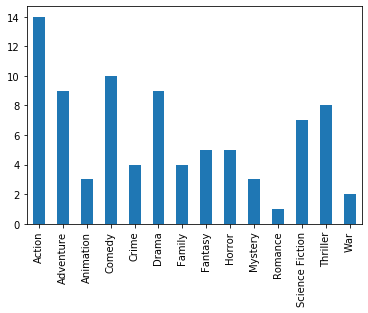

In [181]:
July_genre_count.plot(kind='bar')

In [187]:
movie_and_budget_last_5years.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_y,original_language,...,profit,month_year,month,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,23811,"[12, 28, 14]",299536,en,...,1.748134e+09,2018-04,4,Adventure,Action,Fantasy,NaN,NaN,NaN,NaN
4,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,6.559452e+08,20623,"[28, 12, 14, 878]",141052,en,...,3.559452e+08,2017-11,11,Action,Adventure,Fantasy,Science Fiction,NaN,NaN,NaN
9,12,"May 25, 2018",Solo: A Star Wars Story,275000000.0,213767512.0,3.931513e+08,23845,"[28, 12, 878]",348350,en,...,1.181513e+08,2018-05,5,Action,Adventure,Science Fiction,NaN,NaN,NaN,NaN
13,17,"May 6, 2016",Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,17382,"[12, 28, 878]",271110,en,...,8.900694e+08,2016-05,5,Adventure,Action,Science Fiction,NaN,NaN,NaN,NaN
14,18,"Mar 25, 2016",Batman v Superman: Dawn of Justice,250000000.0,330360194.0,8.675003e+08,17390,"[28, 12, 14]",209112,en,...,6.175003e+08,2016-03,3,Action,Adventure,Fantasy,NaN,NaN,NaN,NaN


In [188]:
movie_and_budget_last_5years.columns

Index(['id_x', 'release_date_x', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'Unnamed: 0', 'genre_ids', 'id_y',
       'original_language', 'original_title', 'popularity', 'release_date_y',
       'title', 'vote_average', 'vote_count', 'profit', 'month_year', 'month',
       'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5',
       'genre_6'],
      dtype='object')

In [191]:
split_by_genre = movie_and_budget_last_5years.melt(id_vars=['id_x', 'release_date_x', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'Unnamed: 0', 'genre_ids', 'id_y',
       'original_language', 'original_title', 'popularity', 'release_date_y',
       'title', 'vote_average', 'vote_count', 'profit', 'month_year', 'month'], 
        var_name="gen_x", 
        value_name="Genres")

In [200]:
July_split_by_genre = July.melt(id_vars=['id_x', 'release_date_x', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'Unnamed: 0', 'genre_ids', 'id_y',
       'original_language', 'original_title', 'popularity', 'release_date_y',
       'title', 'vote_average', 'vote_count', 'profit', 'month_year', 'month'], 
        var_name="gen_x", 
        value_name="Genres")

In [202]:
July_avg_profit_genre = July_split_by_genre.groupby(['Genres']).mean().sort_values(by=['profit'], ascending=False)
July_median_profit_genre = July_split_by_genre.groupby(['Genres']).median().sort_values(by=['profit'], ascending=False)
July_std_profit_genre = July_split_by_genre.groupby(['Genres']).std().sort_values(by=['profit'])

In [198]:
avg_profit_genre = split_by_genre.groupby(['Genres']).mean().sort_values(by=['profit'], ascending=False)
median_profit_genre = split_by_genre.groupby(['Genres']).median().sort_values(by=['profit'], ascending=False)
std_profit_genre = split_by_genre.groupby(['Genres']).std().sort_values(by=['profit'])

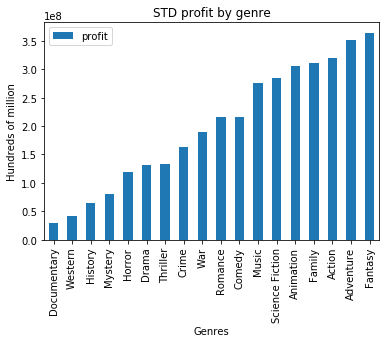

In [203]:
std_profit_genre[['profit']].plot(kind='bar')
plt.title('STD profit by genre')
plt.ylabel('Hundreds of million');

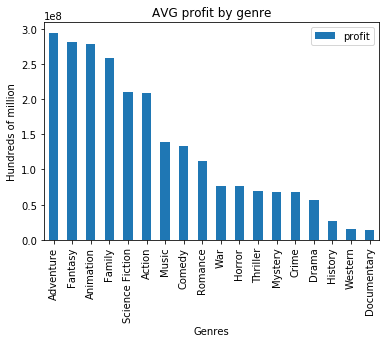

In [196]:
avg_profit_genre[['profit']].plot(kind='bar')
plt.title('AVG profit by genre')
plt.ylabel('Hundreds of million');

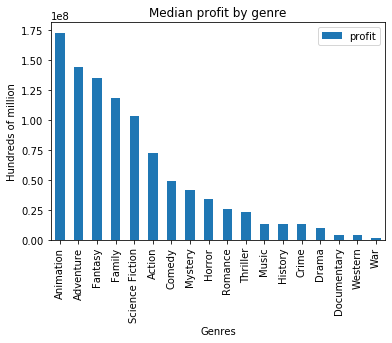

In [197]:
median_profit_genre[['profit']].plot(kind='bar')
plt.title('Median profit by genre')
plt.ylabel('Hundreds of million');

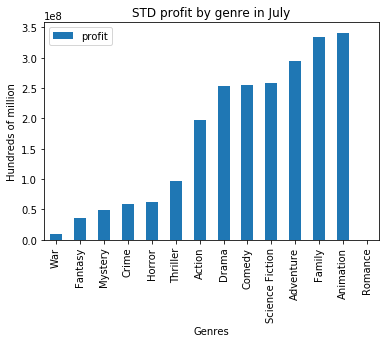

In [204]:
July_std_profit_genre[['profit']].plot(kind='bar')
plt.title('STD profit by genre in July')
plt.ylabel('Hundreds of million');

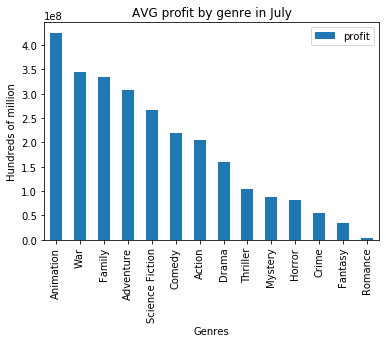

In [206]:
July_avg_profit_genre[['profit']].plot(kind='bar')
plt.title('AVG profit by genre in July')
plt.ylabel('Hundreds of million');

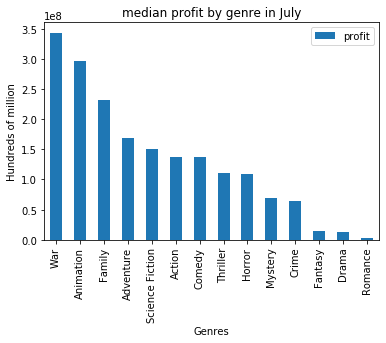

In [207]:
July_median_profit_genre[['profit']].plot(kind='bar')
plt.title('median profit by genre in July')
plt.ylabel('Hundreds of million');

In [208]:
ratings_basics

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama
3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
4,tt1060240,6.5,21,Até Onde?,Até Onde?,2011,73.0,"Mystery,Thriller"
...,...,...,...,...,...,...,...,...
73851,tt9805820,8.1,25,Caisa,Caisa,2018,84.0,Documentary
73852,tt9844256,7.5,24,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120.0,"Action,Animation,Sci-Fi"
73853,tt9851050,4.7,14,Sisters,Sisters,2019,NaN,"Action,Drama"
73854,tt9886934,7.0,5,The Projectionist,The Projectionist,2019,81.0,Documentary


In [209]:
type(ratings_basics['numvotes'][0])

numpy.int64

In [236]:
ratings_basics.drop(ratings_basics[ratings_basics['numvotes'] < 100].index, inplace = True)

In [237]:
ratings_basics

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
5,tt1069246,6.2,326,Habana Eva,Habana Eva,2010,106.0,"Comedy,Romance"
6,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport"
7,tt1130982,6.4,571,The Night Clerk,Avant l'aube,2011,104.0,"Drama,Thriller"
...,...,...,...,...,...,...,...,...
73828,tt9471952,7.1,338,Sükut Evi,Sükut Evi,2018,97.0,Drama
73831,tt9558612,3.7,4057,PM Narendra Modi,PM Narendra Modi,2019,136.0,"Biography,Drama"
73832,tt9575726,7.7,161,Ir visi ju vyrai,Ir visi ju vyrai,2019,108.0,"Comedy,Romance"
73844,tt9668598,5.5,317,Musabbar,Musabbar,2019,NaN,"Horror,Thriller"


In [238]:
ratings_basics.drop(ratings_basics[ratings_basics['start_year'] < 2016].index, inplace = True)

In [239]:
ratings_basics

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
9,tt1161457,4.2,148,Vanquisher,The Vanquisher,2016,90.0,"Action,Adventure,Sci-Fi"
49,tt1352393,7.7,1293,Little Secret,Pequeno Segredo,2016,107.0,"Biography,Drama"
153,tt1608290,4.7,59914,Zoolander 2,Zoolander 2,2016,101.0,Comedy
343,tt10243678,6.5,1394,Chopsticks,Chopsticks,2019,100.0,"Comedy,Drama"
...,...,...,...,...,...,...,...,...
73828,tt9471952,7.1,338,Sükut Evi,Sükut Evi,2018,97.0,Drama
73831,tt9558612,3.7,4057,PM Narendra Modi,PM Narendra Modi,2019,136.0,"Biography,Drama"
73832,tt9575726,7.7,161,Ir visi ju vyrai,Ir visi ju vyrai,2019,108.0,"Comedy,Romance"
73844,tt9668598,5.5,317,Musabbar,Musabbar,2019,NaN,"Horror,Thriller"


In [241]:
genres = ratings_basics["genres"].str.split(",", expand = True)

In [232]:
ratings_basics

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,[Documentary]
9,tt1161457,4.2,148,Vanquisher,The Vanquisher,2016,90.0,"[Action, Adventure, Sci-Fi]"
49,tt1352393,7.7,1293,Little Secret,Pequeno Segredo,2016,107.0,"[Biography, Drama]"
153,tt1608290,4.7,59914,Zoolander 2,Zoolander 2,2016,101.0,[Comedy]
343,tt10243678,6.5,1394,Chopsticks,Chopsticks,2019,100.0,"[Comedy, Drama]"
...,...,...,...,...,...,...,...,...
73828,tt9471952,7.1,338,Sükut Evi,Sükut Evi,2018,97.0,[Drama]
73831,tt9558612,3.7,4057,PM Narendra Modi,PM Narendra Modi,2019,136.0,"[Biography, Drama]"
73832,tt9575726,7.7,161,Ir visi ju vyrai,Ir visi ju vyrai,2019,108.0,"[Comedy, Romance]"
73844,tt9668598,5.5,317,Musabbar,Musabbar,2019,NaN,"[Horror, Thriller]"


In [242]:
genres

,0,1,2
1,Documentary,None,None
9,Action,Adventure,Sci-Fi
49,Biography,Drama,None
153,Comedy,None,None
343,Comedy,Drama,None
...,...,...,...
73828,Drama,None,None
73831,Biography,Drama,None
73832,Comedy,Romance,None
73844,Horror,Thriller,None


In [243]:
ratings_basics_genre = pd.concat([ratings_basics, genres], axis=1)
ratings_basics_genre.head()

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,0,1,2
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary,Documentary,None,None
9,tt1161457,4.2,148,Vanquisher,The Vanquisher,2016,90.0,"Action,Adventure,Sci-Fi",Action,Adventure,Sci-Fi
49,tt1352393,7.7,1293,Little Secret,Pequeno Segredo,2016,107.0,"Biography,Drama",Biography,Drama,None
153,tt1608290,4.7,59914,Zoolander 2,Zoolander 2,2016,101.0,Comedy,Comedy,None,None
343,tt10243678,6.5,1394,Chopsticks,Chopsticks,2019,100.0,"Comedy,Drama",Comedy,Drama,None


In [251]:
ratings_basics_genre.rename(columns={0: "genre_0", 1: "genre_1", 2: "genre_2"}, inplace=True)

In [256]:
ratings_basics_genre = ratings_basics_genre.melt(id_vars=['tconst', 'averagerating', 'numvotes', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes', 'genres'], 
        var_name="gen_x", 
        value_name="Genres_long")

In [269]:
runtime_ratings = ratings_basics_genre.groupby(['runtime_minutes']).mean()

In [277]:
runtime_ratings.drop(runtime_ratings[runtime_ratings.index > 350].index, inplace = True)

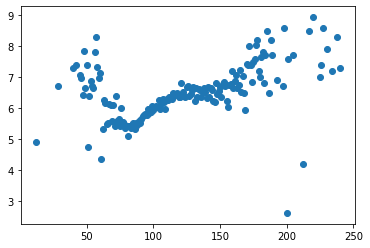

In [278]:
plt.scatter(runtime_ratings.index,runtime_ratings['averagerating']);


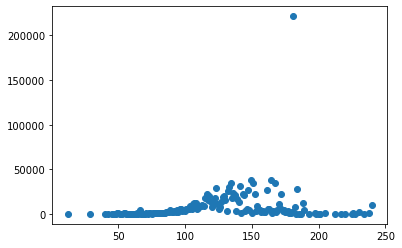

In [279]:
plt.scatter(runtime_ratings.index,runtime_ratings['numvotes']);

In [264]:
avg_rating_by_genre = ratings_basics_genre.groupby(['Genres_long']).mean().sort_values(by=['averagerating'], ascending=False)
median_rating_by_genre = ratings_basics_genre.groupby(['Genres_long']).median().sort_values(by=['averagerating'], ascending=False)
std_rating_by_genre = ratings_basics_genre.groupby(['Genres_long']).std().sort_values(by=['averagerating'])

avg_numvotes_by_genre = ratings_basics_genre.groupby(['Genres_long']).mean().sort_values(by=['numvotes'], ascending=False)
median_numvotes_by_genre = ratings_basics_genre.groupby(['Genres_long']).median().sort_values(by=['numvotes'], ascending=False)
std_numvotes_by_genre = ratings_basics_genre.groupby(['Genres_long']).std().sort_values(by=['numvotes'])


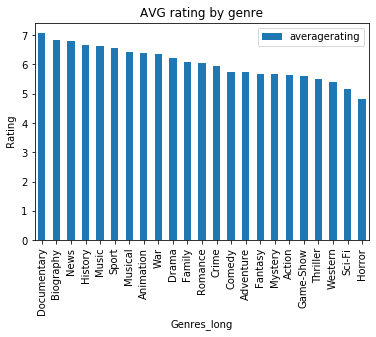

In [260]:
avg_rating_by_genre[['averagerating']].plot(kind='bar')
plt.title('AVG rating by genre')
plt.ylabel(' Rating ');

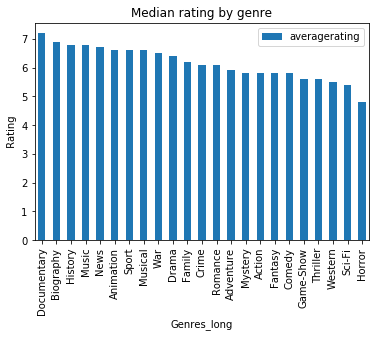

In [262]:
median_rating_by_genre[['averagerating']].plot(kind='bar')
plt.title('Median rating by genre')
plt.ylabel(' Rating ');

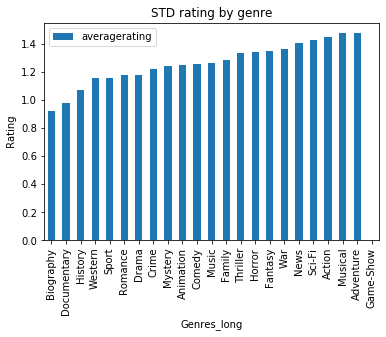

In [263]:
std_rating_by_genre[['averagerating']].plot(kind='bar')
plt.title('STD rating by genre')
plt.ylabel(' Rating ');

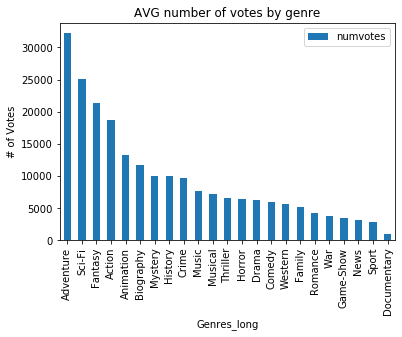

In [265]:
avg_numvotes_by_genre[['numvotes']].plot(kind='bar')
plt.title('AVG number of votes by genre')
plt.ylabel('# of Votes');

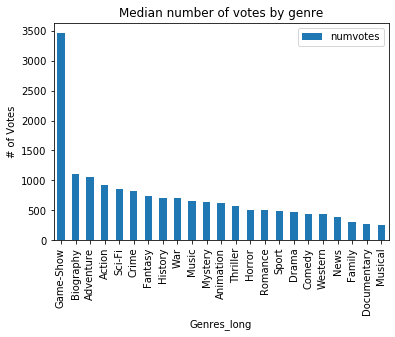

In [266]:
median_numvotes_by_genre[['numvotes']].plot(kind='bar')
plt.title('Median number of votes by genre')
plt.ylabel('# of Votes');

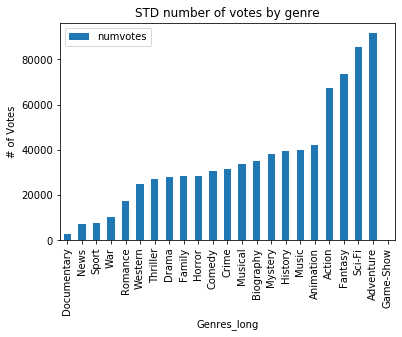

In [267]:
std_numvotes_by_genre[['numvotes']].plot(kind='bar')
plt.title('STD number of votes by genre')
plt.ylabel('# of Votes');